In [2]:
!pip install pm4py
!pip install Streamlit
!pip install pyngrok

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
import numpy as np
import plotly.express as px
import streamlit as st

In [ ]:
%%writefile app.py
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
import numpy as np
import plotly.express as px
import streamlit as st

st.markdown("""
    <style>
    /* Whole page */
    body {
        background-color: #f7f9fc;
        font-family: 'Roboto', sans-serif;
    }
    /* Sidebar */
    [data-testid="stSidebar"] {
        background-color: #ffffff;
        padding: 1rem;
        width: 220px;
    }
    [data-testid="stSidebar"] > div:first-child {
        padding-top: 1rem;
    }
    /* Header title */
    .main-title {
        font-family: 'Poppins', sans-serif;
        text-align: center;
        font-size: 3rem;
        color: #2E86C1;
        margin-bottom: 0.5rem;
        margin-top: -1rem;
    }
    /* Subtitle under header */
    .subtitle {
        text-align: center;
        font-size: 1.2rem;
        color: #555;
        margin-bottom: 2rem;
    }
    </style>
""", unsafe_allow_html=True)

# Display main title
st.markdown('<h3 class="main-title">Human Reference Atlas (HRA) Analyzing and Visualizing Google Analytics Data for HRA User Interfaces</h3>', unsafe_allow_html=True)
st.markdown('<p class="subtitle">Exploring User Behavior with Visual Analytics</p>', unsafe_allow_html=True)

# Add a horizontal line after the title
st.markdown('---')


# st.markdown("""
#     <style>
#         [data-testid="stSidebar"] {
#             width: 200px !important;
#         }
#         [data-testid="stSidebar"] > div:first-child {
#             width: 200px !important;
#         }
#     </style>
# """, unsafe_allow_html=True)

st.sidebar.title("📊 Select Visualization")

plot_option = st.sidebar.selectbox(
    "Choose a chart to view:",
    (
        "Statistical Analysis",
        "Weekly Events Area Chart",
        "Clicks Heatmap",
        "Event Hierarchy Treemap",
        "Event Flow (Sankey Diagram)",
        "User Sequences (Sunburst)"
    )
)

for _ in range(2):
    st.sidebar.markdown("&nbsp;", unsafe_allow_html=True)

# Footer content
st.sidebar.markdown("### Team members")
st.sidebar.markdown("""
- Virija Nandamudi
- Madhumitha Gannavaram
- Sri Sai Lahari Gandrapu
- Anmol Munnolli
""")

csv_url = "https://github.com/virijanandamudi/Info_Viz_Project/releases/download/v1.0/hra-export.csv"
local_file = "hra-export.csv"
if not os.path.exists(local_file):
    with st.spinner("Downloading data..."):
        import urllib.request
        urllib.request.urlretrieve(csv_url, local_file)

df = pd.read_csv(local_file)
df = df[~df['event_name'].isin(['page_view'])]
df = df[~df['event_name'].isin(['webpage'])]
df['event_category'] = df['event_category'].fillna('No Category')
df['event_label'] = df['event_label'].fillna('No Label')
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='us', errors='coerce')
df['user_first_touch_timestamp'] = pd.to_datetime(df['user_first_touch_timestamp'], unit='us', errors='coerce')
df['user_first_touch_timestamp'] = df['user_first_touch_timestamp'].fillna(df['event_timestamp'])
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='us', errors='coerce')
df['user_first_touch_timestamp'] = pd.to_datetime(df['user_first_touch_timestamp'], unit='us', errors='coerce')
invalid_event_ts = df['event_timestamp'].isnull().sum()
invalid_first_touch = df['user_first_touch_timestamp'].isnull().sum()
threshold = 100
if invalid_event_ts < threshold:
    df = df.dropna(subset=['event_timestamp'])
if invalid_first_touch < threshold:
    df = df.dropna(subset=['user_first_touch_timestamp'])
click_events = df[df['event_name'] == 'click']
button_click_counts = click_events['event_label'].value_counts()
most_clicked = button_click_counts.idxmax()
least_clicked = button_click_counts.idxmin()

df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='us')
df['event_week'] = df['event_timestamp'].dt.to_period('W')

events_over_time = df.groupby(['event_week', 'event_name']).size().unstack('event_name', fill_value=0)
events_over_time.index = events_over_time.index.to_timestamp()
N = 10
col_sums = events_over_time.sum()
col_sums_sorted = col_sums.sort_values(ascending=False)
top_cols = col_sums_sorted.index[:N]
events_top = events_over_time[top_cols].copy()
other_cols = col_sums_sorted.index[N:]


#stacked area graph


if len(other_cols) > 0:
    events_top['Other'] = events_over_time[other_cols].sum(axis=1)

event_color_map = {
    'Other': "#AA4499",                   # magenta
    'rotation_update': "#999933",         # olive
    'opacity_update': "#44AA99",          # teal (replaces gray)
    'first_visit': "#332288",             # deep navy
    '[Illustrator] Set Selection on Hover': "#DDCC77",  # warm sand
    'user_engagement': "#117733",         # dark green
    'scroll': "#CC6677",                  # muted rose
    'session_start': "#E69F00",           # orange
    'nodes_selected_by_ids': "#0072B2",   # blue
    'nodes_selected': "#F0E442",          # yellow
    'placement': "#56B4E9"                # sky blue
}

fig = go.Figure()
for col in events_top.columns:
    y_vals = events_top[col].values
    x_vals = events_top.index
    hover_texts = []

    for x, y in zip(x_vals, y_vals):
        if y > 1400:
            hover_texts.append(f"🚨 High activity detected!\n{col} had {y} events")
        else:
            hover_texts.append(f"{col}: {y} events")

    fig.add_trace(go.Scatter(
        x=x_vals,
        y=y_vals,
        stackgroup='one',
        name=col,
        mode='lines',
        line=dict(width=0.5, color=event_color_map.get(col, '#000000')),
        customdata=np.array(hover_texts).reshape(-1, 1),
        hovertemplate="<b>%{x}</b><br>%{customdata[0]}<extra></extra>"
    ))

fig.update_layout(
    title='Distribution of User Events Over Time (Weekly Aggregation)',
    xaxis_title='Week',
    yaxis_title='Number of Events',
    legend_title='Event Name',
    hovermode='x unified',
    template='plotly_white',
    height=600,
    width=1000
)

if plot_option == "Weekly Events Area Chart":
    st.subheader("Weekly Events Area Chart")
    fig.update_layout(width=1000, height=600)
    st.plotly_chart(fig, use_container_width=False)
    st.markdown("**Question: What is the distribution of different user events over time?**")
    st.markdown("""
    - This stacked area chart visualizes how frequently different event types occur each week, clearly showing their temporal distribution while emphasizing which interactions dominate overall activity and how their proportions shift over time.
    - Mid-January shows a spike in total user activity, followed by a drop and a rebound in early February, with the chart revealing repeated rises and falls in weekly event counts—suggesting users interact more heavily with the system during specific timeframes.
    """)



# heatmap
valid_clicks = click_events[
    (click_events['event_label'] != "No Label") &
    (click_events['event_category'] != "No Category")
].copy()

# --- Step 2: Parse timestamps safely ---
valid_clicks['event_timestamp'] = pd.to_datetime(valid_clicks['event_timestamp'], unit='s', errors='coerce')
if valid_clicks['event_timestamp'].isna().all():
    valid_clicks['event_timestamp'] = pd.to_datetime(valid_clicks['event_timestamp'], unit='us', errors='coerce')

# Extract hour and date
valid_clicks['hour'] = valid_clicks['event_timestamp'].dt.hour
valid_clicks['date'] = valid_clicks['event_timestamp'].dt.date

# --- Step 3: Compute click counts and cumulative share ---
label_counts = valid_clicks['event_label'].value_counts()
cumulative = label_counts.cumsum() / label_counts.sum()
top_labels = cumulative[cumulative <= 0.5].index

if len(top_labels) == 0:
    top_labels = label_counts.index[:1]

# Filter only those top labels
filtered_clicks = valid_clicks[valid_clicks['event_label'].isin(top_labels)].copy()

# --- Step 4: Compute percentage contribution of each label in the top 50% ---
top_label_counts = label_counts[top_labels]
top_label_percentages = (top_label_counts / top_label_counts.sum() * 50).round(1)  # sum to 50%

# --- Step 5: Create a label → "label (X%)" mapping ---
label_map = {label: f"{label} ({pct}%)" for label, pct in top_label_percentages.items()}
filtered_clicks['event_label_named'] = filtered_clicks['event_label'].map(label_map)

# --- Step 6: Count clicks per label, date, and hour ---
daily_counts = filtered_clicks.groupby(['event_label_named', 'date', 'hour']).size().reset_index(name='daily_count')

# --- Step 7: Average daily counts per hour and round to integer ---
average_per_hour = (
    daily_counts
    .groupby(['event_label_named', 'hour'])['daily_count']
    .mean()
    .round(0)
    .astype(int)
    .reset_index()
)

# --- Step 8: Pivot into heatmap structure ---
heat_data = average_per_hour.pivot(index='event_label_named', columns='hour', values='daily_count').fillna(0)
heat_data = heat_data.reindex(columns=range(24), fill_value=0)

# --- Step 9: Sort by total row sum ---
heat_data['total'] = heat_data.sum(axis=1)
heat_data = heat_data.sort_values('total', ascending=False).drop(columns='total')

# --- Step 10: Add annotations to each cell ---
max_val = heat_data.values.max()
annotations = []
for i, label in enumerate(heat_data.index):
    for j, hour in enumerate(heat_data.columns):
        value = heat_data.iloc[i, j]
        annotations.append(dict(
            x=hour,
            y=label,
            text=str(int(value)),
            showarrow=False,
            font=dict(
                color="white" if value > max_val * 0.6 else "black",
                size=11
            ),
            xanchor="center",
            yanchor="middle"
        ))

# --- Step 11: Plot the heatmap ---
heatfig = go.Figure(data=go.Heatmap(
    z=heat_data.values,
    x=heat_data.columns,
    y=heat_data.index,
    colorscale='YlGnBu',
    hoverongaps=False,
    colorbar=dict(title='Avg Clicks per Day'),
    zmin=0,
    showscale=True
))

heatfig.update_layout(
    title='Average Daily Clicks by Hour (Top 50% Cumulative Labels, with % Contribution)',
    title_font_size=20,
    xaxis_title='Hour of Day',
    yaxis_title='UI Element (Label % within 50%)',
    xaxis=dict(dtick=1),
    yaxis=dict(autorange="reversed"),
    annotations=annotations,
    template='plotly_white',
    margin=dict(t=80, l=120, r=40, b=40),
    height=400,
    width=1000
)

if plot_option == "Clicks Heatmap":
    st.subheader("Clicks Heatmap")
    heatfig.update_layout(width=1400, height=400)
    st.plotly_chart(heatfig, use_container_width=False)
    st.markdown("**Question: Which UI elements are used most frequently, and at what times of day do users interact with them the most?**")
    st.markdown("""
    - the heatmap shows the average number of daily clicks per hour for the UI elements that collectively account for the top 50% of total user interactions.
    - "Selected (clicked) a node" is the most used action, accounting for 12.8% of the top 50% interactions, peaking sharply at 2 PM with 20 clicks/day on average.
    - Most frequent UI elements, including Close Bottom Sheet, Open Search, and Close Search, show increased activity between 12 PM and 3 PM, suggesting peak interaction occurs in early afternoon.
    - Early morning (before 8 AM) and late night (after 9 PM) show little to no activity, indicating limited user engagement outside standard hours.
    """)




#treemap
# Step 1: Clean data
df_clicks = df[df['event_name'].notna() & df['event_category'].notna()].copy()
df_clicks['event_label'] = df_clicks['event_label'].fillna('').astype(str).str.strip()
df_clicks['clean_label'] = df_clicks['event_label'].str.replace(r'Iri:\s*http\S+\s*-?\s*', '', regex=True).str.strip()
df_clicks['Sex'] = df_clicks['clean_label'].str.extract(r'Sex:\s*([^\-]+)')[0].fillna('Not specified').str.strip()
df_clicks['Side'] = df_clicks['clean_label'].str.extract(r'Side:\s*([^\-]+)')[0].fillna('Not specified').str.strip()

# Step 2: Remove placeholders
def keep_if_meaningful(val):
    val = str(val).strip().lower()
    if val.startswith("no ") or val in ["no category", "not specified", ""]:
        return None
    return val.strip()

df_cleaned = df_clicks.copy()
df_cleaned['event_name'] = df_cleaned['event_name'].apply(keep_if_meaningful)
df_cleaned['event_category'] = df_cleaned['event_category'].apply(keep_if_meaningful)
df_cleaned['Sex'] = df_cleaned['Sex'].apply(keep_if_meaningful)
df_cleaned['Side'] = df_cleaned['Side'].apply(keep_if_meaningful)

# Step 3: Build variable-depth hierarchy
df_cleaned['hierarchy'] = df_cleaned[['event_name', 'event_category', 'Sex', 'Side']] \
    .apply(lambda x: '/'.join([str(val) for val in x if pd.notna(val)]), axis=1)

# Step 4: Count and split levels
df_path_counts = df_cleaned.groupby('hierarchy').size().reset_index(name='count')
df_path_counts[['L1', 'L2', 'L3', 'L4']] = df_path_counts['hierarchy'].str.split('/', expand=True).iloc[:, :4]

# Step 5: Drop rows that are not full leaves
df_path_counts['depth'] = df_path_counts[['L1', 'L2', 'L3', 'L4']].notna().sum(axis=1)
df_path_counts = df_path_counts[df_path_counts['depth'] > 1].copy()

# Step 6: Build treemap
treefig = px.treemap(
    df_path_counts,
    path=['L1', 'L2', 'L3', 'L4'],
    values='count',
    color='count',
    color_continuous_scale='Viridis',
    title='Hierarchical Treemap with Variable Depth (Only Meaningful Leaves)'
)

treefig.update_layout(margin=dict(t=60, l=25, r=25, b=25))
if plot_option == "Event Hierarchy Treemap":
    st.subheader("Event Hierarchy Treemap")
    treefig.update_layout(width=1000, height=600)
    st.plotly_chart(treefig, use_container_width=False)
    st.markdown("Spacial Analaysis-TreeMap: What we did: To explore spatial patterns in UI interactions, we built a hierarchical treemap from cleaned event data, organizing interactions by meaningful layers—event type, category, and sub-attributes like Sex and Side—while excluding placeholder or ambiguous labels. This variable-depth structure reflects the UI’s nested design (e.g., event → component → filter), capturing only interpretable paths and enabling both high-level and detailed insights in one view.")
    st.markdown("""
    - 'placement' and 'nodes_selected'/'nodes_selected_by_ids' dominate interaction counts, indicating core usage patterns center around element selection and placement.
    - "Knee, R placement" stands out as the most frequent detailed action.
    - Other frequently used elements include "opacity_update", "filter_update", and "rotation_update", which are critical interaction tools.
    - Fine-grained filters such as Sex: Female and Side: Left appear in smaller but still visible portions, showing that user-driven filtering is used, albeit less frequently.
    """)




df_pm = df[['user_pseudo_id', 'event_timestamp', 'event_name']].copy()

# Rename columns for PM4Py format
df_pm.columns = ['case:concept:name', 'time:timestamp', 'concept:name']

# Drop any rows with missing data
df_pm = df_pm.dropna(subset=['case:concept:name', 'time:timestamp', 'concept:name'])

# Sort by case and time
df_pm = df_pm.sort_values(by=['case:concept:name', 'time:timestamp'])

parameters = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: "case:concept:name"}
event_log = log_converter.apply(df_pm, variant=log_converter.Variants.TO_EVENT_LOG, parameters=parameters)

df_trans = df[['user_pseudo_id', 'event_timestamp', 'event_name']].copy()
df_trans = df_trans.sort_values(by=['user_pseudo_id', 'event_timestamp'])
df_trans['next_event'] = df_trans.groupby('user_pseudo_id')['event_name'].shift(-1)

# --- Count transitions ---
transition_counts = df_trans.dropna(subset=['next_event'])
transition_counts = transition_counts.groupby(['event_name', 'next_event']).size().reset_index(name='count')
transition_counts = transition_counts.sort_values(by='count', ascending=False)

#sankey

core_events = [
    'first_visit', 'session_start', 'scroll', 'click',
    'user_engagement', 'filter_update', 'filter_removed',
    'nodes_selected', 'nodes_selected_by_ids',
    'set_organ', 'set_position', 'set_radius', 'placement',
    'opacity_update', 'selection_change', 'Vitescce Mounted',
    'Scroll in Scatterplot', 'Scroll Out Scatterplot'
]

# --- Step 2: Filter transitions between these expanded core events ---
filtered_transitions = transition_counts[
    (transition_counts['event_name'].isin(core_events)) &
    (transition_counts['next_event'].isin(core_events)) &
    (transition_counts['event_name'] != transition_counts['next_event']) &
    (transition_counts['count'] >= 10)  # Lower threshold for richer flow
]

# --- Step 3: Create unique label list and mapping ---
# Create unique list of events (nodes)
# --- Step 1: Create unique labels from BOTH event_name and next_event ---
import plotly.graph_objects as go

# --- Assuming you already have 'filtered_transitions' dataframe ready

# Step 1: Unique labels
unique_labels = pd.unique(filtered_transitions[['event_name', 'next_event']].values.ravel())
labels = list(unique_labels)

# Step 2: Mapping
label_to_index = {label: idx for idx, label in enumerate(labels)}

# Step 3: Source, target, value
sources = filtered_transitions['event_name'].map(label_to_index).tolist()
targets = filtered_transitions['next_event'].map(label_to_index).tolist()
values = filtered_transitions['count'].tolist()

# Step 4: Build Sankey
sankeyfig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=40,                # More spacing between nodes
        thickness=20,          # Node thickness
        line=dict(color="black", width=0.8),  # Slightly thicker node border
        label=labels,
        color="lightskyblue",   # Nicer node color
        hoverlabel=dict(
            font_size=13,
            font_family="Roboto"  # Font for hover tooltip
        )
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(100, 100, 100, 0.3)"  # Semi-transparent gray links
    )
)])

# Step 5: Layout
sankeyfig.update_layout(
    title_text="User Event Flow (Sankey Diagram)",
    font_size=12,                     # 🔥 Slightly larger
    font_family="Roboto, sans-serif", # 🔥 Change font globally
    font_color="black",                # 🔥 Dark clean font
    height=700,                        # Compact height
    width=950,                         # Compact width
    template="plotly_white"
)

# Step 6: Display in Streamlit
if plot_option == "Event Flow (Sankey Diagram)":
  st.subheader("User Event Flow (Sankey Diagram)")
  st.plotly_chart(sankeyfig, use_container_width=False, config={"staticPlot": False, "renderer": "svg"})
  st.markdown("Question: What are the most common sequences of user interactions throughout a session?")
  st.markdown("""
  - This Sankey diagram has improved visibility and styling.
  - Key event flows are cleanly separated with better font readability and contrast.
  """)




#sunburst

df_sequence = df[['user_pseudo_id', 'event_timestamp', 'event_name']].copy()
df_sequence = df_sequence.sort_values(by=['user_pseudo_id', 'event_timestamp'])

# --- Step 2: Group by user and extract the first 4 events per session ---
df_sequence['step'] = df_sequence.groupby('user_pseudo_id').cumcount()
df_trimmed = df_sequence[df_sequence['step'] < 4]

# --- Step 3: Pivot to wide format to get sequence columns ---
df_pivot = df_trimmed.pivot(index='user_pseudo_id', columns='step', values='event_name')
df_pivot.columns = ['Step 1', 'Step 2', 'Step 3', 'Step 4']
df_pivot = df_pivot.fillna('END')  # pad short sessions

# --- Step 4: Count unique sequences ---
sequence_counts = df_pivot.value_counts().reset_index(name='count')

# --- Step 5: Plot sunburst ---
sunburstfig = px.sunburst(
    sequence_counts,
    path=['Step 1', 'Step 2', 'Step 3', 'Step 4'],
    values='count',
    title='User Event Sequences (First 4 Steps)',
    width=900,
    height=900
)
if plot_option == "User Sequences (Sunburst)":
    st.subheader("User Event Sequences (First 4 Steps)")
    sunburstfig.update_layout(width=1000, height=600)
    st.plotly_chart(sunburstfig, use_container_width=False)
    st.markdown("""
    - To explore user flow from a session-based perspective, we created a sunburst diagram by extracting and visualizing the first four sequential events per user. By grouping events per user ID, ranking them by timestamp, and padding shorter sequences, we structured a clean representation of early interaction paths.
    - The most dominant starting point was first_visit, followed primarily by session_start, scroll, and user_engagement. The diagram revealed that while a few patterns are very common, there's a long tail of diverse user paths beyond the second step. This approach highlights both consistency in initial engagement and fragmentation in deeper interactions.
    """)





#statistical analysis
if plot_option == "Statistical Analysis":
    st.markdown("**Data**")

    st.dataframe(df.head(5))

    st.markdown("How often were key features like spatial search and opacity adjustment used, and which UI buttons received the most and least user interaction?")
    st.markdown("""
    - **Spatial search**: 1,810 times
    - **opacity**: 2,887 times
    - **Total Events Recorded**: 251,000
      **indicating that while these are niche interactions, they may hold high value for advanced users.**
    - **top 5 most clicked actions**:
        1. "Selected (clicked) a node"
        2. "Close Bottom Sheet Information"
        3. "Open Search"
        4. "Close Search"
        5."Select/Deselect Search Filters"
    """)



Overwriting app.py


In [ ]:
!ngrok config add-authtoken 2P8RePU0A83WmmJm9XOPiLPNIEd_3xr5VkNSeTa5LEKS4NAfJ

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
import time

!pkill streamlit
public_url = ngrok.connect(addr="8501", proto="http")
print("🌍 Streamlit is live at:", public_url)

!streamlit run app.py &
time.sleep(3)


🌍 Streamlit is live at: NgrokTunnel: "https://349b-34-125-34-194.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.34.194:8501

/content/app.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['event_category'] = df['event_category'].fillna('No Category')
/content/app.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['event_label'] = df['event_

In [5]:
df.head()

,user_pseudo_id,hostname,page_location,event_date,user_first_touch_timestamp,event_timestamp,event_name,event_category,event_label
0,1.038633e+09,portal.hubmapconsortium.org,https://portal.hubmapconsortium.org/ccf-eui,20250211,1.739323e+15,1739322701478089,first_visit,NaN,NaN
1,1.038633e+09,portal.hubmapconsortium.org,https://portal.hubmapconsortium.org/ccf-eui,20250211,1.739323e+15,1739322701478089,session_start,NaN,NaN
2,1.038633e+09,portal.hubmapconsortium.org,https://portal.hubmapconsortium.org/ccf-eui,20250211,1.739323e+15,1739322701478089,page_view,NaN,NaN
3,1.038633e+09,portal.hubmapconsortium.org,https://portal.hubmapconsortium.org/ccf-eui,20250211,1.739323e+15,1739322701479382,selection_change,dropdown,Sex:Both
4,1.038633e+09,portal.hubmapconsortium.org,https://portal.hubmapconsortium.org/ccf-eui,20250211,1.739323e+15,1739322701479382,filter_update,filter_content,sex:Both


In [ ]:
df.describe()

,user_pseudo_id,event_date,user_first_touch_timestamp,event_timestamp
count,2.508530e+05,2.508530e+05,2.344690e+05,2.508530e+05
mean,9.134415e+08,2.024813e+07,1.725401e+15,1.737050e+15
std,6.876223e+08,3.727307e+03,2.030068e+13,1.446123e+12
min,2.307182e+05,2.024121e+07,1.629140e+15,1.734071e+15
25%,3.092871e+08,2.025010e+07,1.724182e+15,1.735773e+15
50%,6.690593e+08,2.025012e+07,1.735340e+15,1.736977e+15
75%,1.537702e+09,2.025013e+07,1.737054e+15,1.738331e+15
max,2.147207e+09,2.025021e+07,1.739336e+15,1.739336e+15


In [ ]:
df.columns

Index(['user_pseudo_id', 'hostname', 'page_location', 'event_date',
       'user_first_touch_timestamp', 'event_timestamp', 'event_name',
       'event_category', 'event_label'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250853 entries, 0 to 250852
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   user_pseudo_id              250853 non-null  float64
 1   hostname                    249169 non-null  object 
 2   page_location               250853 non-null  object 
 3   event_date                  250853 non-null  int64  
 4   user_first_touch_timestamp  234469 non-null  float64
 5   event_timestamp             250853 non-null  int64  
 6   event_name                  250853 non-null  object 
 7   event_category              208683 non-null  object 
 8   event_label                 206489 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 17.2+ MB


In [ ]:
# Remove rows where event_name is "page_view"
df = df[~df['event_name'].isin(['page_view'])]

# Remove rows where event_category is "webpage"
df = df[~df['event_name'].isin(['webpage'])]

# Optionally, check the updated DataFrame info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 73989 entries, 0 to 250851
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_pseudo_id              73989 non-null  float64
 1   hostname                    73989 non-null  object 
 2   page_location               73989 non-null  object 
 3   event_date                  73989 non-null  int64  
 4   user_first_touch_timestamp  71194 non-null  float64
 5   event_timestamp             73989 non-null  int64  
 6   event_name                  73989 non-null  object 
 7   event_category              52522 non-null  object 
 8   event_label                 50511 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 5.6+ MB
None


In [ ]:
df.isnull().sum()

,0
user_pseudo_id,0
hostname,0
page_location,0
event_date,0
user_first_touch_timestamp,2795
event_timestamp,0
event_name,0
event_category,21467
event_label,23478


In [ ]:
# Replace null values in event_category and event_label with default placeholders
df['event_category'] = df['event_category'].fillna('No Category')
df['event_label'] = df['event_label'].fillna('No Label')

# Optionally, verify the changes
print(df[['event_category', 'event_label']].isnull().sum())

event_category    0
event_label       0
dtype: int64


In [ ]:
# List the columns of interest with null values
null_columns = ['hostname', 'user_first_touch_timestamp', 'event_category', 'event_label']

# Loop through each column and display 10 rows where the column has null values
for col in null_columns:
    print(f"\nRows with null values in '{col}':")
    display(df[df[col].isnull()].head(10))


Rows with null values in 'hostname':


,user_pseudo_id,hostname,page_location,event_date,user_first_touch_timestamp,event_timestamp,event_name,event_category,event_label



Rows with null values in 'user_first_touch_timestamp':


,user_pseudo_id,hostname,page_location,event_date,user_first_touch_timestamp,event_timestamp,event_name,event_category,event_label
528,1.400424e+08,portal.hubmapconsortium.org,https://portal.hubmapconsortium.org/ccf-eui,20250211,NaN,1739256017281665,selection_change,dropdown,Sex:Both
529,1.400424e+08,portal.hubmapconsortium.org,https://portal.hubmapconsortium.org/ccf-eui,20250211,NaN,1739256017281665,filter_update,filter_content,sex:Both
996,1.595456e+09,portal.hubmapconsortium.org,https://portal.hubmapconsortium.org/organ/kidney,20250211,NaN,1739298316058641,session_start,No Category,No Label
998,1.595456e+09,portal.hubmapconsortium.org,https://portal.hubmapconsortium.org/organ/kidney,20250211,NaN,1739298321976331,organ_lookup_success,organ,Iri: http://purl.obolibrary.org/obo/UBERON_000...
999,1.595456e+09,portal.hubmapconsortium.org,https://portal.hubmapconsortium.org/organ/kidney,20250211,NaN,1739298321976331,Vitessce Mounted,Visualization - Organ,Kidney
1000,1.595456e+09,portal.hubmapconsortium.org,https://portal.hubmapconsortium.org/organ/kidney,20250211,NaN,1739298321976331,organ_lookup_success,organ,Iri: http://purl.obolibrary.org/obo/UBERON_000...
1001,1.595456e+09,portal.hubmapconsortium.org,https://portal.hubmapconsortium.org/organ/kidney,20250211,NaN,1739298321976331,organ_lookup_success,organ,Iri: http://purl.obolibrary.org/obo/UBERON_000...
1002,1.595456e+09,portal.hubmapconsortium.org,https://portal.hubmapconsortium.org/organ/kidney,20250211,NaN,1739298365310580,user_engagement,No Category,No Label
1004,1.595456e+09,portal.hubmapconsortium.org,https://portal.hubmapconsortium.org/organ/kidney,20250211,NaN,1739298466637514,organ_lookup_success,organ,Iri: http://purl.obolibrary.org/obo/UBERON_000...
1005,1.595456e+09,portal.hubmapconsortium.org,https://portal.hubmapconsortium.org/organ/kidney,20250211,NaN,1739298466637514,Vitessce Mounted,Visualization - Organ,Kidney



Rows with null values in 'event_category':


,user_pseudo_id,hostname,page_location,event_date,user_first_touch_timestamp,event_timestamp,event_name,event_category,event_label



Rows with null values in 'event_label':


,user_pseudo_id,hostname,page_location,event_date,user_first_touch_timestamp,event_timestamp,event_name,event_category,event_label


In [ ]:


# Ensure both columns are in datetime format.
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='us', errors='coerce')
df['user_first_touch_timestamp'] = pd.to_datetime(df['user_first_touch_timestamp'], unit='us', errors='coerce')

# Replace NaN in user_first_touch_timestamp with the corresponding event_timestamp value.
df['user_first_touch_timestamp'] = df['user_first_touch_timestamp'].fillna(df['event_timestamp'])

In [ ]:
print(df['user_first_touch_timestamp'].isnull().sum())

0


In [ ]:
# Convert event_timestamp safely: Coerce out-of-bound values to NaT
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='us', errors='coerce')

# Convert user_first_touch_timestamp similarly
df['user_first_touch_timestamp'] = pd.to_datetime(df['user_first_touch_timestamp'], unit='us', errors='coerce')

# Print the number of NaT values (coerced values) in each column
invalid_event_ts = df['event_timestamp'].isnull().sum()
invalid_first_touch = df['user_first_touch_timestamp'].isnull().sum()

print("Number of invalid event_timestamp values:", invalid_event_ts)
print("Number of invalid user_first_touch_timestamp values:", invalid_first_touch)

# If the number of invalid values is low, you might choose to drop those rows
threshold = 100  # You can adjust this threshold based on your dataset size and analysis requirements
if invalid_event_ts < threshold:
    df = df.dropna(subset=['event_timestamp'])
if invalid_first_touch < threshold:
    df = df.dropna(subset=['user_first_touch_timestamp'])

Number of invalid event_timestamp values: 0
Number of invalid user_first_touch_timestamp values: 0


In [ ]:
df.duplicated().sum()

np.int64(20044)

In [ ]:
spatial_search_count = (df['event_category'] == 'spatial_search_ui').sum()
print(f"Spatial search was used {spatial_search_count} times in the EUI.")

Spatial search was used 1810 times in the EUI.


In [ ]:
opacity_update_count = (df['event_name'] == 'opacity_update').sum()
print(f"Opacity was changed {opacity_update_count} times in the RUI.")

Opacity was changed 2887 times in the RUI.


In [ ]:
# Filter the DataFrame for rows where event_name is 'click'
click_events = df[df['event_name'] == 'click']

# Count the occurrences of each value in 'event_label'
button_click_counts = click_events['event_label'].value_counts()

# Displaying the results
print("Button Click Counts:")
print(button_click_counts)

# Identifying the most and least clicked buttons
most_clicked = button_click_counts.idxmax()
least_clicked = button_click_counts.idxmin()

print(f"The most clicked UI button is '{most_clicked}' with {button_click_counts.max()} clicks.")
print(f"The least clicked UI button is '{least_clicked}' with {button_click_counts.min()} clicks.")

Button Click Counts:
event_label
No Label                                                                                                1449
Selected (clicked) a node                                                                                 89
Close Bottom Sheet Information                                                                            65
Open Search                                                                                               58
Close Search                                                                                              53
                                                                                                        ... 
Clicked a node label: {"name":"pericentral hepatocyte","groupName":"Cell Types","oid":"CL:0019029","       1
Clicked a node label: {"name":"CD45","groupName":"Biomarkers","oid":"HGNC:9666","type":"BM","x":1400       1
Clicked a node label: {"name":"Delta cell","groupName":"Cell Types","oid":"CL:0000173","type":"

In [ ]:
# 1. Convert the event_timestamp to datetime with microseconds
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='us')

# 2. Create a new column representing weekly periods
#    This will group timestamps by each week (Sunday-Saturday by default).
df['event_week'] = df['event_timestamp'].dt.to_period('W')

# 3. Group by (event_week, event_name) and count the occurrences
events_over_time = df.groupby(['event_week', 'event_name']).size().unstack('event_name', fill_value=0)

# 4. Convert the PeriodIndex to a regular DateTimeIndex (for plotting convenience)
#    This sets the date of each weekly period to the start of that period (e.g., Monday).
events_over_time.index = events_over_time.index.to_timestamp()

# 5. Identify the top N event types
N = 10
col_sums = events_over_time.sum()
col_sums_sorted = col_sums.sort_values(ascending=False)
top_cols = col_sums_sorted.index[:N]

# 6. Create a new DataFrame with only these top event types
events_top = events_over_time[top_cols].copy()

# Sum the remaining event types into an 'Other' column
other_cols = col_sums_sorted.index[N:]
if len(other_cols) > 0:
    events_top['Other'] = events_over_time[other_cols].sum(axis=1)

# Improved color assignments (colorblind-safe and highly differentiated)
event_color_map = {
    'Other': "#AA4499",                   # magenta
    'rotation_update': "#999933",         # olive
    'opacity_update': "#44AA99",          # teal (replaces gray)
    'first_visit': "#332288",             # deep navy
    '[Illustrator] Set Selection on Hover': "#DDCC77",  # warm sand
    'user_engagement': "#117733",         # dark green
    'scroll': "#CC6677",                  # muted rose
    'session_start': "#E69F00",           # orange
    'nodes_selected_by_ids': "#0072B2",   # blue
    'nodes_selected': "#F0E442",          # yellow
    'placement': "#56B4E9"                # sky blue
}

# Create the Plotly stacked area chart
fig = go.Figure()

# Ensure each event uses its assigned color
for col in events_top.columns:
    fig.add_trace(go.Scatter(
        x=events_top.index,
        y=events_top[col],
        stackgroup='one',
        name=col,
        mode='lines',
        line=dict(width=0.5, color=event_color_map.get(col, '#000000'))  # fallback is black if not mapped
    ))

fig.update_layout(
    title='Distribution of User Events Over Time (Weekly Aggregation)',
    xaxis_title='Week',
    yaxis_title='Number of Events',
    legend_title='Event Name',
    hovermode='x unified',
    template='plotly_white',
    height=600,
    width=1000
)

fig.show()

In [ ]:
# Step 1: Clean data
df_clicks = df[df['event_name'].notna() & df['event_category'].notna()].copy()
df_clicks['event_label'] = df_clicks['event_label'].fillna('').astype(str).str.strip()
df_clicks['clean_label'] = df_clicks['event_label'].str.replace(r'Iri:\s*http\S+\s*-?\s*', '', regex=True).str.strip()
df_clicks['Sex'] = df_clicks['clean_label'].str.extract(r'Sex:\s*([^\-]+)')[0].fillna('Not specified').str.strip()
df_clicks['Side'] = df_clicks['clean_label'].str.extract(r'Side:\s*([^\-]+)')[0].fillna('Not specified').str.strip()

# Step 2: Remove placeholders
def keep_if_meaningful(val):
    val = str(val).strip().lower()
    if val.startswith("no ") or val in ["no category", "not specified", ""]:
        return None
    return val.strip()

df_cleaned = df_clicks.copy()
df_cleaned['event_name'] = df_cleaned['event_name'].apply(keep_if_meaningful)
df_cleaned['event_category'] = df_cleaned['event_category'].apply(keep_if_meaningful)
df_cleaned['Sex'] = df_cleaned['Sex'].apply(keep_if_meaningful)
df_cleaned['Side'] = df_cleaned['Side'].apply(keep_if_meaningful)

# Step 3: Build variable-depth hierarchy
df_cleaned['hierarchy'] = df_cleaned[['event_name', 'event_category', 'Sex', 'Side']] \
    .apply(lambda x: '/'.join([str(val) for val in x if pd.notna(val)]), axis=1)

# Step 4: Count and split levels
df_path_counts = df_cleaned.groupby('hierarchy').size().reset_index(name='count')
df_path_counts[['L1', 'L2', 'L3', 'L4']] = df_path_counts['hierarchy'].str.split('/', expand=True).iloc[:, :4]

# Step 5: Drop rows that are not full leaves
df_path_counts['depth'] = df_path_counts[['L1', 'L2', 'L3', 'L4']].notna().sum(axis=1)
df_path_counts = df_path_counts[df_path_counts['depth'] > 1].copy()

# Step 6: Build treemap
fig = px.treemap(
    df_path_counts,
    path=['L1', 'L2', 'L3', 'L4'],
    values='count',
    color='count',
    color_continuous_scale='Viridis',
    title='Hierarchical Treemap with Variable Depth (Only Meaningful Leaves)'
)

fig.update_layout(margin=dict(t=60, l=25, r=25, b=25))
fig.show()


In [ ]:

import altair as alt

# --- Step 1: Prepare click data ---
df_clicks = df[df['event_name'] == 'click'].copy()

# Ensure it's fully pandas-native (avoid Narwhals issue)
df_clicks = pd.DataFrame(df_clicks)

# Clean up and filter "No Label"
df_clicks['event_label'] = df_clicks['event_label'].astype(str).str.strip()
df_clicks = df_clicks[df_clicks['event_label'] != "No Label"]

# --- Step 2: Get top 20 event labels ---
top_labels = df_clicks['event_label'].value_counts().head(20).reset_index()
top_labels.columns = ['event_label', 'count']
top_labels = pd.DataFrame(top_labels)  # Ensure it's clean for Altair

# --- Step 3: Build Altair chart ---
chart = alt.Chart(top_labels).mark_bar(
    cornerRadiusTopLeft=6,
    cornerRadiusTopRight=6,
    opacity=0.9
).encode(
    x=alt.X('count:Q', title='Click Count'),
    y=alt.Y('event_label:N', sort='-x', title=None),
    color=alt.Color('count:Q', scale=alt.Scale(scheme='tealblues'), legend=None),
    tooltip=[alt.Tooltip('event_label:N', title='UI Element'),
             alt.Tooltip('count:Q', title='Clicks')]
).properties(
    width=750,
    height=500,
    title='UI Element Usage — Treemap-Inspired Horizontal Chart'
).configure_axis(
    grid=False,
    labelFontSize=13,
    titleFontSize=14
).configure_view(
    stroke=None
).configure_title(
    fontSize=20,
    font='Helvetica Neue',
    anchor='start'
)

# --- Step 4: Display (in Jupyter/Colab/Streamlit) ---
chart


NotImplementedError: Attribute _native_frame is not supported for metadata-only dataframes.

Hint: you probably called `nw.from_native` on an object which isn't fully supported by Narwhals, yet implements `__dataframe__`. If you would like to see this kind of object supported in Narwhals, please open a feature request at https://github.com/narwhals-dev/narwhals/issues.

alt.Chart(...)

In [ ]:
# --- Step 1: Filter out placeholder values ---
valid_clicks = click_events[
    (click_events['event_label'] != "No Label") &
    (click_events['event_category'] != "No Category")
]

# --- Step 2: Compute label counts and cumulative usage ---
label_counts = valid_clicks['event_label'].value_counts()
cumulative = label_counts.cumsum() / label_counts.sum()

# --- Step 3: Select the top 50% most used labels ---
top_threshold = 0.5
top_labels = cumulative[cumulative <= top_threshold].index

if len(top_labels) == 0:
    top_labels = label_counts.index[:1]

print("Top 50% labels (valid):", top_labels)

# --- Step 4: Filter the data for selected labels ---
final_filtered_clicks = valid_clicks[valid_clicks['event_label'].isin(top_labels)].copy()

# --- Step 5: Convert timestamp to hour of day ---
final_filtered_clicks['event_timestamp'] = pd.to_datetime(
    final_filtered_clicks['event_timestamp'], unit='us', errors='coerce'
)
final_filtered_clicks['hour'] = final_filtered_clicks['event_timestamp'].dt.hour

# --- Step 6: Create pivot table: rows = label, columns = hour ---
heat_data = final_filtered_clicks.pivot_table(
    index='event_label',
    columns='hour',
    values='user_pseudo_id',
    aggfunc='count',
    fill_value=0
)

# Ensure x-axis has all 24 hours
full_hours = list(range(24))
heat_data = heat_data.reindex(columns=full_hours, fill_value=0)

# --- Step 7: Sort rows by total usage ---
heat_data['total'] = heat_data.sum(axis=1)
heat_data = heat_data.sort_values('total', ascending=False)
heat_data['row_label'] = [f"{label} ({total:,})" for label, total in zip(heat_data.index, heat_data['total'])]
heat_data = heat_data.drop(columns='total')
heat_data.index = heat_data['row_label']
heat_data = heat_data.drop(columns='row_label')

# --- Step 8: Prepare annotations and hover text ---
max_val = heat_data.values.max()
total_clicks = heat_data.values.sum()

hover_text = [[f"{val:,} clicks<br>{val / total_clicks:.2%}" for val in row] for row in heat_data.values]

annotations = []
for i, label in enumerate(heat_data.index):
    for j, hour in enumerate(heat_data.columns):
        value = heat_data.iloc[i, j]
        annotations.append(dict(
            x=hour,
            y=label,
            text=f"{value:,}",
            showarrow=False,
            font=dict(
                color="white" if value > max_val * 0.6 else "black",
                size=11
            ),
            xanchor="center",
            yanchor="middle"
        ))

# --- Step 9: Plot with Plotly ---
fig = go.Figure(data=go.Heatmap(
    z=heat_data.values,
    x=heat_data.columns,
    y=heat_data.index,
    text=hover_text,
    hoverinfo='text',
    colorscale='Viridis',
    zmin=0,
    showscale=True,
    colorbar=dict(title='Click Count', titleside='right')
))

fig.update_layout(
    title={
        'text': 'UI Click Frequency by Hour<br><sup>Top 50% of UI Labels — Counts Shown on Tiles</sup>',
        'x': 0.01,
        'xanchor': 'left'
    },
    xaxis_title='Hour of Day',
    yaxis_title='UI Element (Event Label)',
    xaxis=dict(dtick=1),
    yaxis=dict(autorange="reversed"),
    annotations=annotations,
    template='plotly_white',
    margin=dict(t=80, l=120, r=40, b=40),
    height=700,
    width=1000
)

fig.update_traces(xgap=1, ygap=1)  # grid spacing for better aesthetics
fig.show()


Top 50% labels (valid): Index(['Selected (clicked) a node', 'Close Bottom Sheet Information',
       'Open Search', 'Close Search', 'Select/Deselect Search Filters',
       'Deselected a node'],
      dtype='object', name='event_label')


In [ ]:
print(final_filtered_clicks[['event_label', 'event_timestamp', 'hour']].head(10))


                         event_label            event_timestamp  hour
5327  Close Bottom Sheet Information 2025-02-11 06:34:23.694473     6
5335  Close Bottom Sheet Information 2025-02-11 06:34:35.158516     6
5357  Close Bottom Sheet Information 2025-02-11 06:34:58.094143     6
5378       Selected (clicked) a node 2025-02-11 06:35:24.030428     6
5380               Deselected a node 2025-02-11 06:35:24.030428     6
5381       Selected (clicked) a node 2025-02-11 06:35:24.030428     6
5384  Close Bottom Sheet Information 2025-02-11 06:35:24.030428     6
5388       Selected (clicked) a node 2025-02-11 06:35:30.208628     6
5468       Selected (clicked) a node 2025-02-11 08:48:39.851080     8
5471               Deselected a node 2025-02-11 08:48:39.851080     8


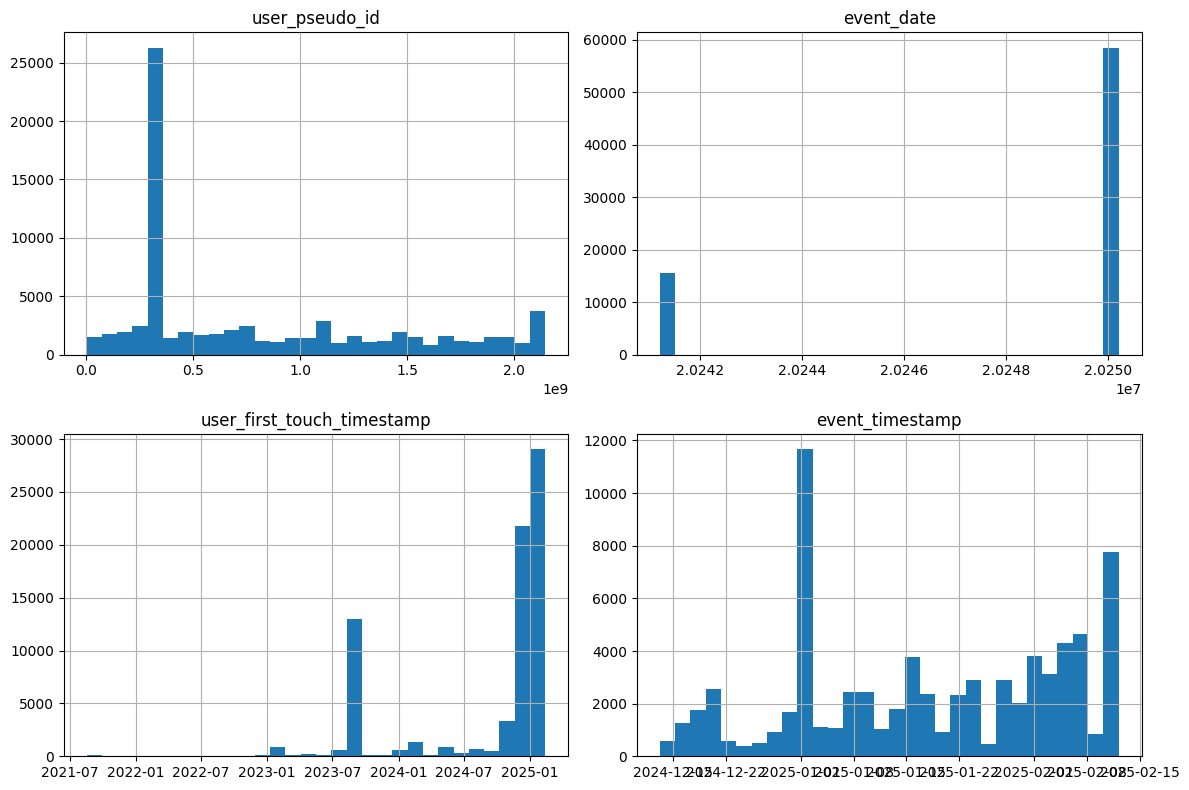

In [ ]:
import matplotlib.pyplot as plt

df.hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()


In [ ]:
df.head(5)

,user_pseudo_id,hostname,page_location,event_date,user_first_touch_timestamp,event_timestamp,event_name,event_category,event_label,event_week
0,1.038633e+09,portal.hubmapconsortium.org,https://portal.hubmapconsortium.org/ccf-eui,20250211,2025-02-12 01:11:41.478089,2025-02-12 01:11:41.478089,first_visit,No Category,No Label,2025-02-10/2025-02-16
1,1.038633e+09,portal.hubmapconsortium.org,https://portal.hubmapconsortium.org/ccf-eui,20250211,2025-02-12 01:11:41.478089,2025-02-12 01:11:41.478089,session_start,No Category,No Label,2025-02-10/2025-02-16
3,1.038633e+09,portal.hubmapconsortium.org,https://portal.hubmapconsortium.org/ccf-eui,20250211,2025-02-12 01:11:41.478089,2025-02-12 01:11:41.479382,selection_change,dropdown,Sex:Both,2025-02-10/2025-02-16
4,1.038633e+09,portal.hubmapconsortium.org,https://portal.hubmapconsortium.org/ccf-eui,20250211,2025-02-12 01:11:41.478089,2025-02-12 01:11:41.479382,filter_update,filter_content,sex:Both,2025-02-10/2025-02-16
5,1.038633e+09,portal.hubmapconsortium.org,https://portal.hubmapconsortium.org/ccf-eui,20250211,2025-02-12 01:11:41.478089,2025-02-12 01:11:45.625856,scroll,No Category,No Label,2025-02-10/2025-02-16


In [ ]:
# Copy and format your existing DataFrame
df_pm = df[['user_pseudo_id', 'event_timestamp', 'event_name']].copy()

# Rename columns for PM4Py format
df_pm.columns = ['case:concept:name', 'time:timestamp', 'concept:name']

# Drop any rows with missing data
df_pm = df_pm.dropna(subset=['case:concept:name', 'time:timestamp', 'concept:name'])

# Sort by case and time
df_pm = df_pm.sort_values(by=['case:concept:name', 'time:timestamp'])

df_pm.head()


,case:concept:name,time:timestamp,concept:name
238896,230718.173453,2024-12-18 15:00:27.646121,first_visit
238897,230718.173453,2024-12-18 15:00:27.646121,session_start
238899,230718.173453,2024-12-18 15:00:32.659987,organ_lookup_success
238900,230718.173453,2024-12-18 15:00:38.350739,"Hover 64,693 Cells"
238901,230718.173453,2024-12-18 15:00:38.350739,"Scroll Out 64,693 Cells"


In [ ]:
# Convert pandas DataFrame to PM4Py event log
parameters = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: "case:concept:name"}
event_log = log_converter.apply(df_pm, variant=log_converter.Variants.TO_EVENT_LOG, parameters=parameters)


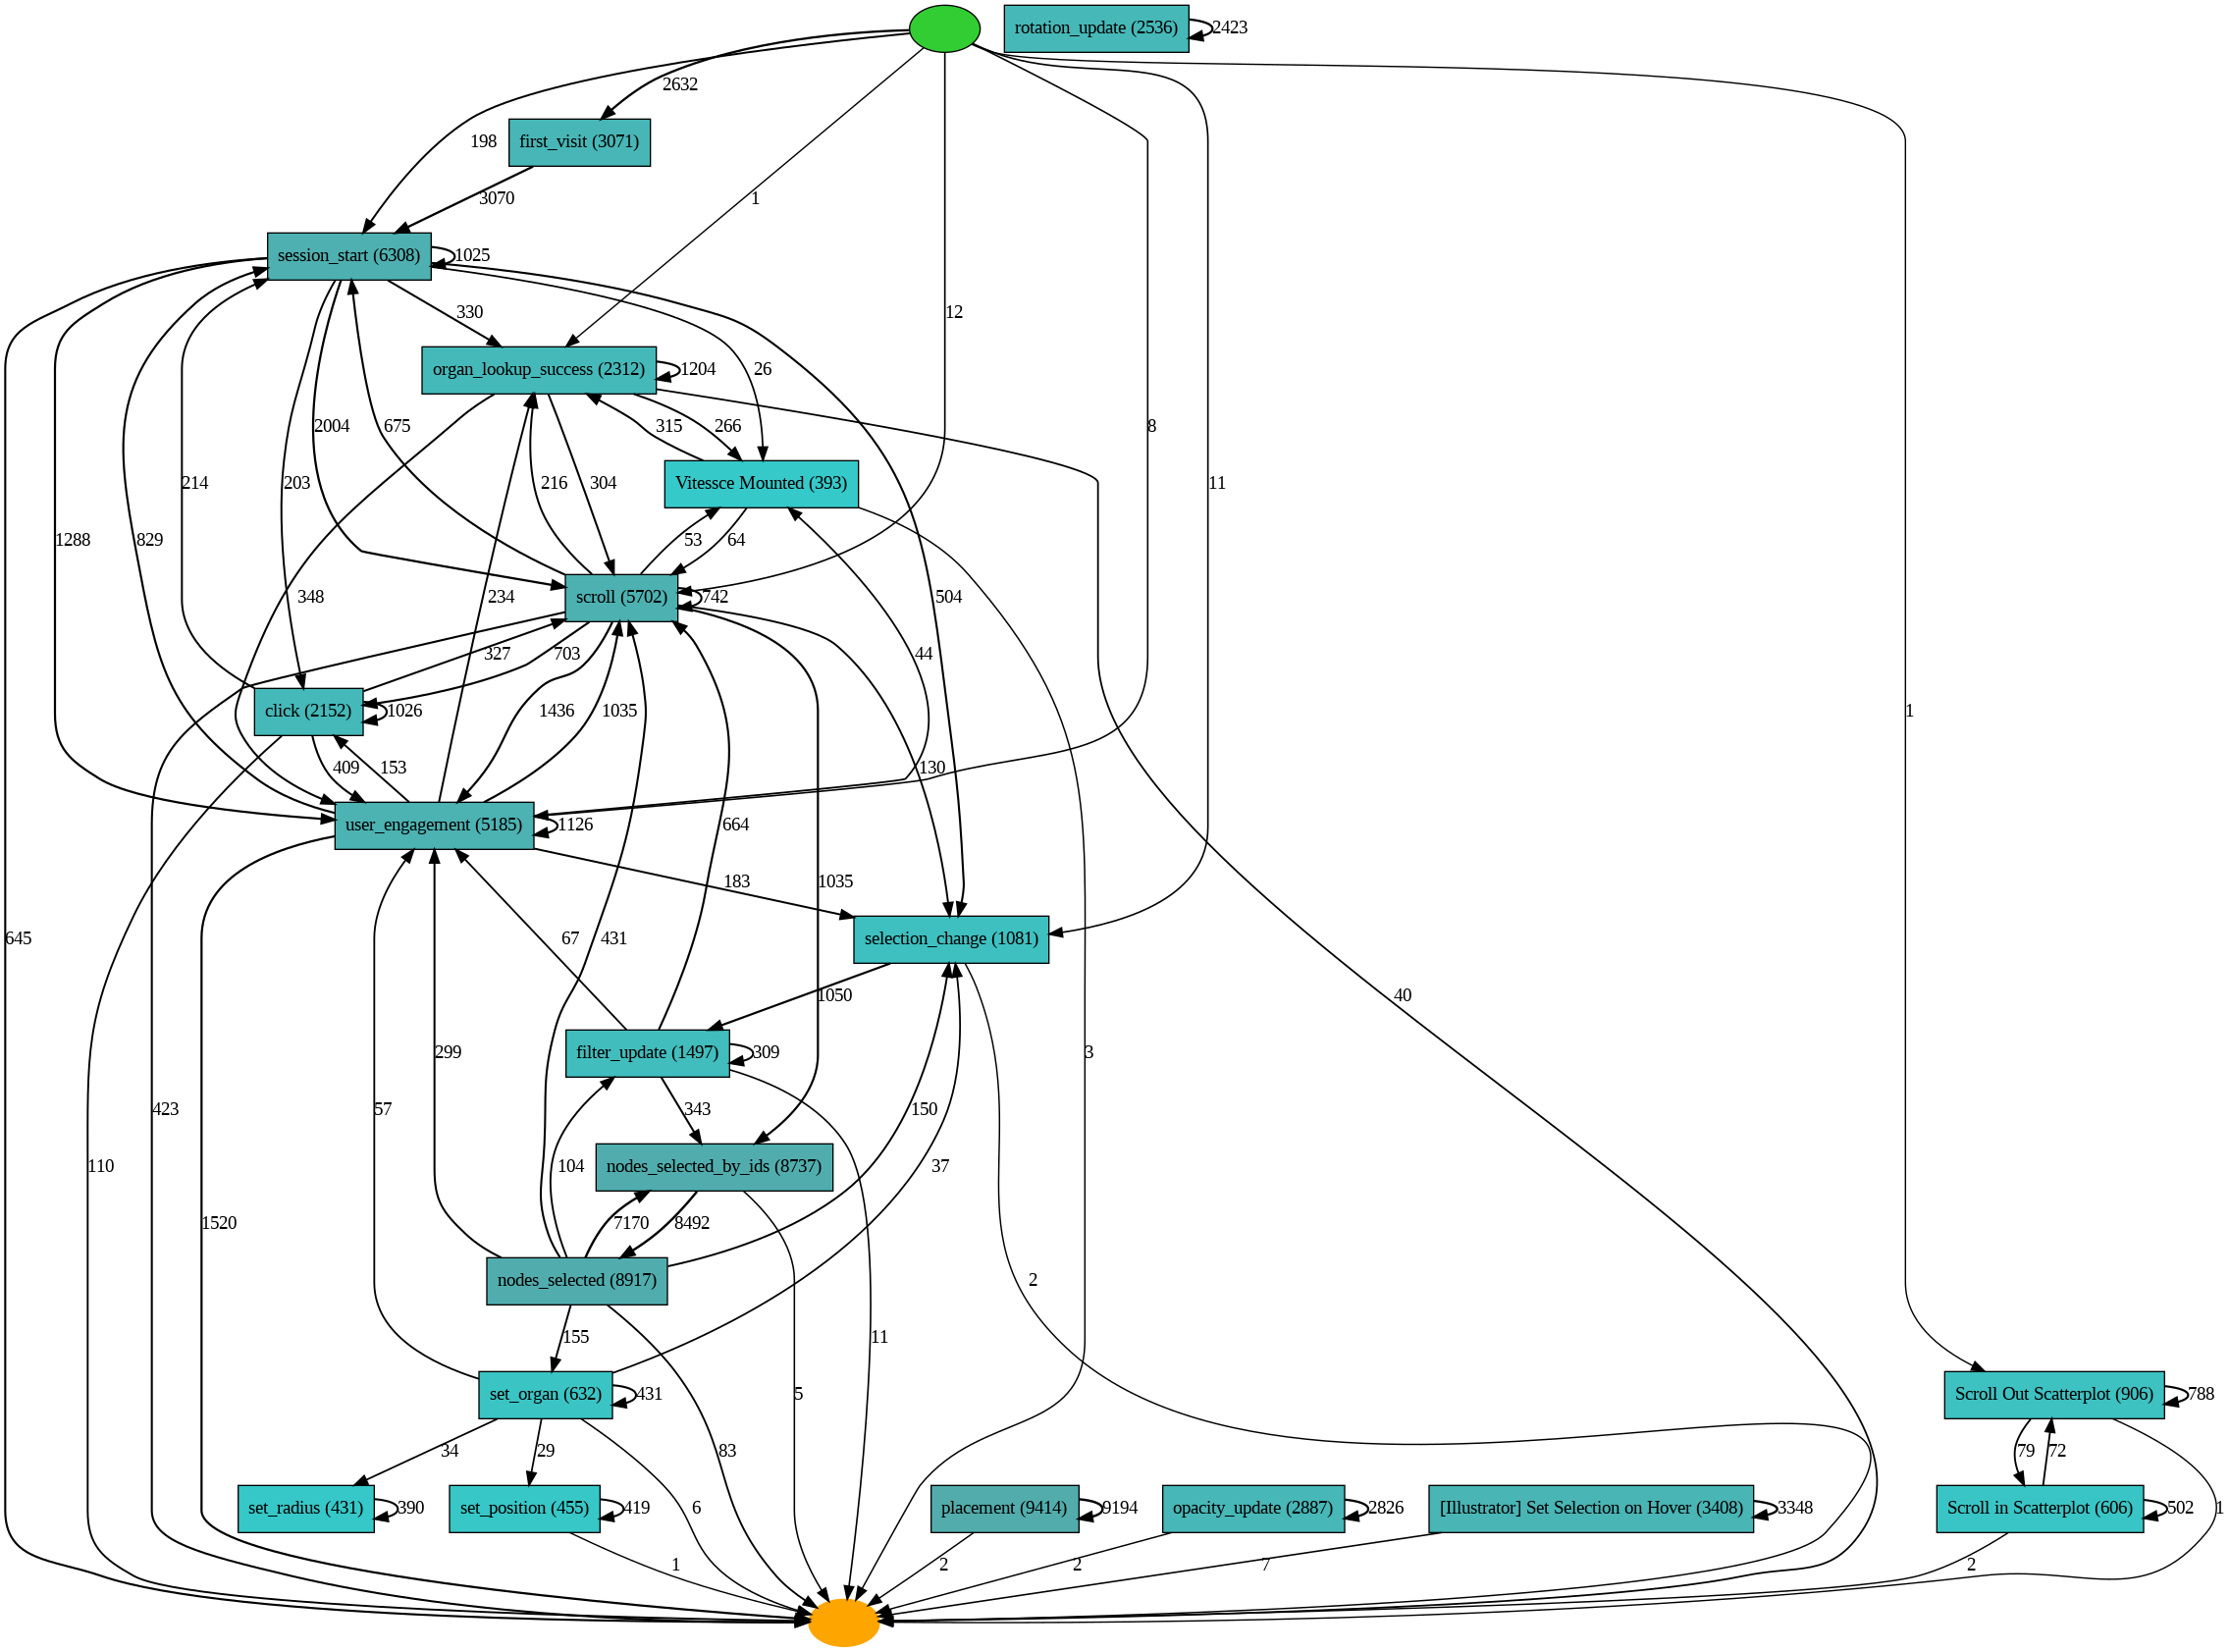

In [ ]:
# Filter df_pm to only top 20 most frequent events
top_events = df_pm['concept:name'].value_counts().head(20).index
df_filtered = df_pm[df_pm['concept:name'].isin(top_events)]

event_log_filtered = log_converter.apply(df_filtered, variant=log_converter.Variants.TO_EVENT_LOG, parameters=parameters)
heu_net_filtered = heuristics_miner.apply_heu(event_log_filtered)
gviz = hn_visualizer.apply(heu_net_filtered)
hn_visualizer.view(gviz)

In [ ]:
# --- Create transition edges for each user session ---
df_trans = df[['user_pseudo_id', 'event_timestamp', 'event_name']].copy()
df_trans = df_trans.sort_values(by=['user_pseudo_id', 'event_timestamp'])
df_trans['next_event'] = df_trans.groupby('user_pseudo_id')['event_name'].shift(-1)

# --- Count transitions ---
transition_counts = df_trans.dropna(subset=['next_event'])
transition_counts = transition_counts.groupby(['event_name', 'next_event']).size().reset_index(name='count')
transition_counts = transition_counts.sort_values(by='count', ascending=False)

# Preview transition edges
transition_counts.head(10)

,event_name,next_event,count
1057,placement,placement,8978
971,nodes_selected_by_ids,nodes_selected,8492
955,nodes_selected,nodes_selected_by_ids,7165
729,[Illustrator] Set Selection on Hover,[Illustrator] Set Selection on Hover,3223
883,first_visit,session_start,3070
982,opacity_update,opacity_update,2598
1110,rotation_update,rotation_update,2412
1217,session_start,scroll,1988
1171,scroll,user_engagement,1387
1225,session_start,user_engagement,1270


In [ ]:
# --- Step 1: Expand core events from Heuristics Miner output ---
core_events = [
    'first_visit', 'session_start', 'scroll', 'click',
    'user_engagement', 'filter_update', 'filter_removed',
    'nodes_selected', 'nodes_selected_by_ids',
    'set_organ', 'set_position', 'set_radius', 'placement',
    'opacity_update', 'selection_change', 'Vitescce Mounted',
    'Scroll in Scatterplot', 'Scroll Out Scatterplot'
]

# --- Step 2: Filter transitions between these expanded core events ---
filtered_transitions = transition_counts[
    (transition_counts['event_name'].isin(core_events)) &
    (transition_counts['next_event'].isin(core_events)) &
    (transition_counts['event_name'] != transition_counts['next_event']) &
    (transition_counts['count'] >= 10)  # Lower threshold for richer flow
]

# --- Step 3: Create unique label list and mapping ---
labels = sorted(list(pd.unique(filtered_transitions[['event_name', 'next_event']].values.ravel())))
label_to_index = {label: i for i, label in enumerate(labels)}

# --- Step 4: Prepare Sankey source-target-value arrays ---
sources = [label_to_index[row['event_name']] for _, row in filtered_transitions.iterrows()]
targets = [label_to_index[row['next_event']] for _, row in filtered_transitions.iterrows()]
values = filtered_transitions['count'].tolist()

# --- Step 5: Build Sankey plot ---
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="lightblue"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    ))])

fig.update_layout(
    title_text="User Event Flow (Sankey Diagram) — Expanded from Heuristics Miner",
    font_size=10,
    height=900,
    width=1100
)

fig.show()


In [ ]:
# --- Step 1: Expand core events from Heuristics Miner output ---
core_events = [
    'first_visit', 'session_start', 'scroll', 'click',
    'user_engagement', 'filter_update', 'filter_removed',
    'nodes_selected', 'nodes_selected_by_ids',
    'set_organ', 'set_position', 'set_radius', 'placement',
    'opacity_update', 'selection_change', 'Vitescce Mounted',
    'Scroll in Scatterplot', 'Scroll Out Scatterplot',
    'view_update', 'review_start', 'register', 'link_clicked',
    'visibility_toggled', 'file_download', 'tag_removed',
    '[Illustrator] Set Selection on Hover'
]


# --- Step 2: Filter transitions between these expanded core events ---
filtered_transitions = transition_counts[
    (transition_counts['event_name'].isin(core_events)) &
    (transition_counts['next_event'].isin(core_events)) &
    (transition_counts['event_name'] != transition_counts['next_event']) &
    (transition_counts['count'] >= 5)  # Lower threshold for richer flow
]

# --- Step 3: Create unique label list and mapping ---
labels = sorted(list(pd.unique(filtered_transitions[['event_name', 'next_event']].values.ravel())))
label_to_index = {label: i for i, label in enumerate(labels)}

# --- Step 4: Prepare Sankey source-target-value arrays ---
sources = [label_to_index[row['event_name']] for _, row in filtered_transitions.iterrows()]
targets = [label_to_index[row['next_event']] for _, row in filtered_transitions.iterrows()]
values = filtered_transitions['count'].tolist()

# --- Step 5: Build Sankey plot ---
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="lightblue"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    ))])

fig.update_layout(
    title_text="User Event Flow (Sankey Diagram) — Expanded from Heuristics Miner",
    font_size=10,
    height=900,
    width=1100
)

fig.show()


In [ ]:
import pandas as pd
import plotly.express as px

# --- Step 1: Extract per-user sequences ---
df_sequence = df[['user_pseudo_id', 'event_timestamp', 'event_name']].copy()
df_sequence = df_sequence.sort_values(by=['user_pseudo_id', 'event_timestamp'])

# --- Step 2: Group by user and extract the first 4 events per session ---
df_sequence['step'] = df_sequence.groupby('user_pseudo_id').cumcount()
df_trimmed = df_sequence[df_sequence['step'] < 4]

# --- Step 3: Pivot to wide format to get sequence columns ---
df_pivot = df_trimmed.pivot(index='user_pseudo_id', columns='step', values='event_name')
df_pivot.columns = ['Step 1', 'Step 2', 'Step 3', 'Step 4']
df_pivot = df_pivot.fillna('END')  # pad short sessions

# --- Step 4: Count unique sequences ---
sequence_counts = df_pivot.value_counts().reset_index(name='count')

# --- Step 5: Plot sunburst ---
fig = px.sunburst(
    sequence_counts,
    path=['Step 1', 'Step 2', 'Step 3', 'Step 4'],
    values='count',
    title='User Event Sequences (First 4 Steps)',
    width=900,
    height=900
)
fig.show()


In [ ]:
from pyngrok import ngrok

!pkill streamlit

public_url = ngrok.connect(port=8501)
print("Streamlit app URL:", public_url)

!streamlit run app.py &
